In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
n_x = 1000
x_array = np.linspace(0, 1, n_x)

R1o = 0.01
R2o = 1e5
Lo = 3.0
Co = 3.0
RL = 1000.0

Lo = 2.0
Co = 2.0

dx = 0.001

R1 = R1o * dx
R2 = R2o / dx
L = Lo * dx
C = Co * dx

G = 1/R2

G = np.ones(x_array.shape) * G

# G[400] = G[400] * 1000000
# G[380:420] = G[380:420] * 1000000


def get_derivative(t, x):
    v = x[:n_x]
    i = x[n_x:]
    
    """
    if t <= 2  and t >= 1:
        u = 1
    else:
        u = 0
    """
    u = np.sin(t)

    v[0] = u
    i[-1] = v[-1]/RL
    
    der_v = np.zeros(v.shape)
    der_i = np.zeros(i.shape)
    
    der_v[1:] = 1/C* (i[:-1] - i[1:] - v[1:] * G[1:])
    der_i[:-1] = 1/L* (-v[1:] + v[:-1] - i[:-1] * R1)
    
    return np.concatenate((der_v, der_i))
    

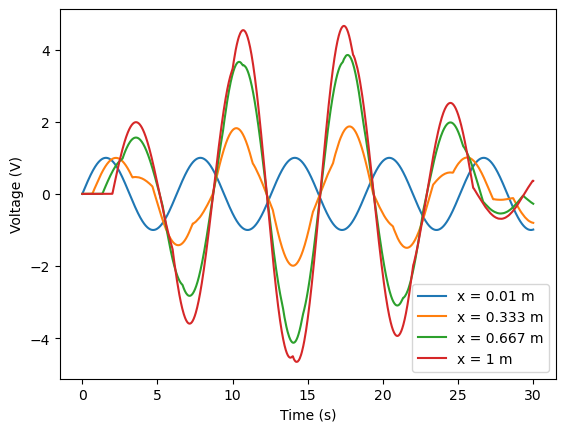

In [3]:
sol = solve_ivp(get_derivative, [0, 30], np.zeros(2*n_x), method='RK45', dense_output=True, rtol=1e-9, atol=1e-9)
plt.plot(sol.t, sol.y[0,:], label="x = 0.01 m")
plt.plot(sol.t, sol.y[int(n_x/3),:], label="x = 0.333 m")
plt.plot(sol.t, sol.y[int(2*n_x/3),:], label="x = 0.667 m")
plt.plot(sol.t, sol.y[n_x-1,:], label= "x = 1 m")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend(loc="lower right")
plt.show()

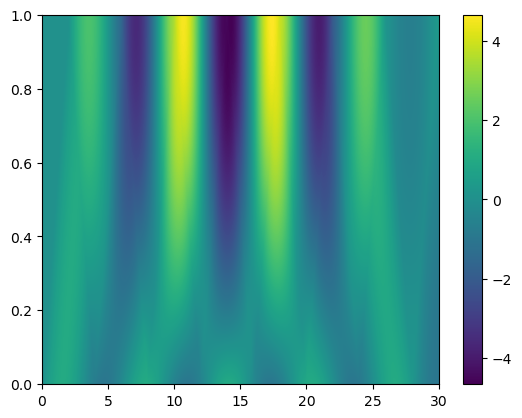

In [4]:
fig = plt.figure()
ax = fig.subplots()

T, X = np.meshgrid(sol.t, x_array)

colormesh = ax.pcolormesh(T, X, sol.y[:n_x, :])
fig.colorbar(colormesh)